# Heat Map Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
DIR = "/workspace/nflbigdatabowl2023"
sys.path.append(DIR)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from shapely import Point as ShapelyPoint
from shapely import Polygon as ShapelyPolygon
from matplotlib.patches import Polygon as PolygonPatch

from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
def vertices_from_shape(shape):
    return list(shape.exterior.coords)

In [5]:
example_shapes = [
    ShapelyPolygon([(0, 0), (0, 1), (1, 1), (1, 0)]),
    ShapelyPolygon([(0, 0), (0, 2), (2, 2), (2, 0)]),
    ShapelyPolygon([(1, 1), (1, 2), (2, 2), (2, 1)]),
]

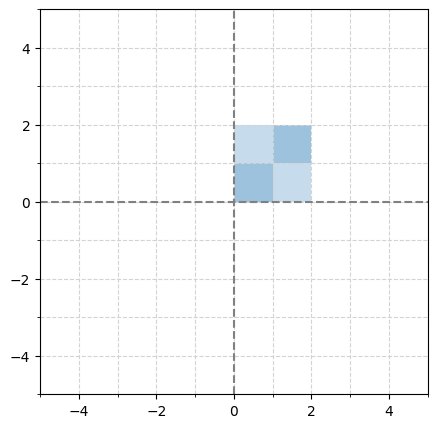

In [6]:
fig, ax = plt.subplots(1, 1)

for shape in example_shapes:
    vertices = vertices_from_shape(shape)
    patch = PolygonPatch(vertices, alpha=0.25)
    ax.add_patch(patch)
    
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.axhline(0, linestyle="--", color="gray")
ax.axvline(0, linestyle="--", color="gray")
ax.grid(which="both", linestyle="--", color="lightgray")
fig.set_size_inches(5, 5)
plt.show()

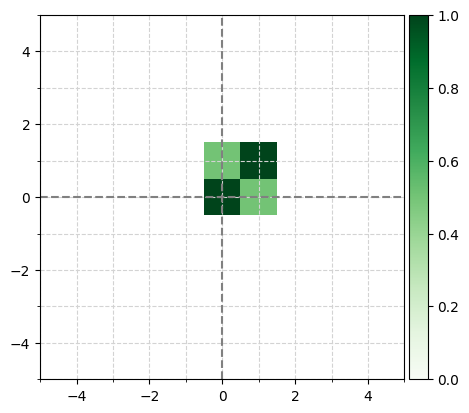

In [7]:
"""
[
     # each column has the same x coord
    [(x=0, y=0), (x=1, y=0)], # each row has the same y coord
    [(x=0, y=1), (x=1, y=1)],
]
"""

heatmap = [
    [1.0, 0.5],
    [0.5, 1.0],
]

fig, ax = plt.subplots(1, 1)

im = ax.imshow(heatmap, cmap="Greens", vmin=0, vmax=1)

# Colorbar on ax code based on : https://stackoverflow.com/a/49037495
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, orientation="vertical")

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.axhline(0, linestyle="--", color="gray")
ax.axvline(0, linestyle="--", color="gray")
ax.grid(which="both", linestyle="--", color="lightgray")
fig.set_size_inches(5, 5)
plt.show()

In [8]:
def heatmap_from_points(points, total, bin_size):
    x = [p[0] for p in points]
    y = [p[1] for p in points]

    # Heatmap binning logic based on: https://stackoverflow.com/a/61632120
    heatmap, xedges, yedges = np.histogram2d(
        x,
        y,
        bins=[
            np.arange(min(x), max(x) + (2 * bin_size), bin_size),
            np.arange(min(y), max(y) + (2 * bin_size), bin_size),
        ],
        # Actually we need to use bin_count / play_count, which
        # would be shape count in this case. So turn density off.
        # Density = bin_count / total_count / bin_area
        # Should we divide by bin area? If the results look wrong,
        # then we can just do bin_count / total_count ourselves.
        # density=True,
    )

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    # Reduce the heatmap values to the range [0, 1] by dividing by
    # the total number of observations the points were sampled from.
    # Note: This is not the total number of points.
    scaled_heatmap = heatmap / total
    
    return scaled_heatmap, extent

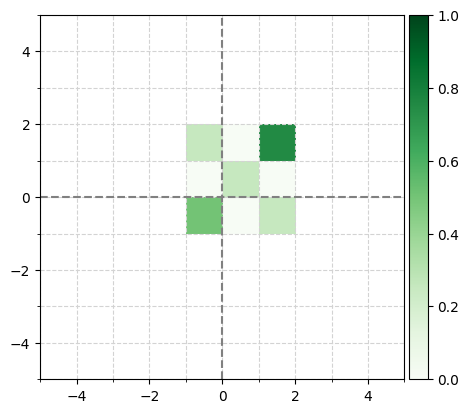

In [9]:
fig, ax = plt.subplots(1, 1)

data = [
    # Format: (x, y)
    (-1, -1),
    (-1, -1),
    (1, -1),
    (-1, 1),
    (1, 1),
    (1, 1),
    (1, 1),
    (0.5, 0.5),
]
heatmap, extent = heatmap_from_points(data, total=4, bin_size=1)

im = ax.imshow(heatmap, extent=extent, cmap="Greens", vmin=0, vmax=1, origin="lower")

# Colorbar on ax code based on : https://stackoverflow.com/a/49037495
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, orientation="vertical")

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.axhline(0, linestyle="--", color="gray")
ax.axvline(0, linestyle="--", color="gray")
ax.grid(which="both", linestyle="--", color="lightgray")
fig.set_size_inches(5, 5)
plt.show()

In [10]:
def sample_points_in_shapes(shapes, bin_start, bin_end, bin_size):
    sample_range = np.arange(bin_start, bin_end + (2 * bin_size), bin_size)
    half_bin = bin_size / 2.0
    points_in_pocket = []
    # This triple for-loop is inefficient, optimize with vector operations.
    for x in sample_range:
        for y in sample_range:
            # Sample point should be in the midpoint of the cell.
            sample_point = (x + half_bin, y + half_bin)
            # Display point for heatmap should be on the cell edge.
            display_point = (x, y)
            # Convert sample point to a shapely point to compare to polygon.
            shape_point = ShapelyPoint(*sample_point)
            for shape in shapes:
                # Also use the exterior so that both points inside the shape
                # use on the border are considered inside the shape.
                is_in_cell = shape.contains(shape_point) or shape.exterior.contains(shape_point)
                # Check the sample point, but save the display point.
                if is_in_cell:
                    points_in_pocket.append(display_point)
    return points_in_pocket

In [11]:
def get_heatmap_from_pocket_shapes(pocket_shapes, bin_start, bin_end, bin_size):
    points_in_pocket = sample_points_in_shapes(
        pocket_shapes,
        bin_start,
        bin_end,
        bin_size,
    )
    total = len(pocket_shapes)
    heatmap, extent = heatmap_from_points(points_in_pocket, total, bin_size)
    return heatmap, extent

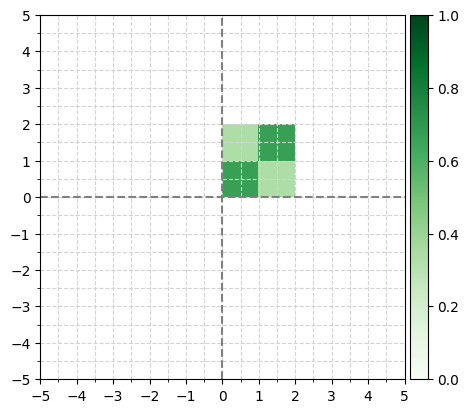

In [12]:
fig, ax = plt.subplots(1, 1)

bin_size = 0.5
heatmap, extent = get_heatmap_from_pocket_shapes(
    example_shapes,
    bin_start=-1,
    bin_end=2,
    bin_size=bin_size,
)

im = ax.imshow(
    heatmap,
    extent=extent,
    cmap="Greens",
    vmin=0,
    vmax=1,
    origin="lower"
)

# Colorbar on ax code based on : https://stackoverflow.com/a/49037495
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, orientation="vertical")

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.xaxis.set_major_locator(MultipleLocator(2 * bin_size))
ax.yaxis.set_major_locator(MultipleLocator(2 * bin_size))
ax.xaxis.set_minor_locator(MultipleLocator(bin_size))
ax.yaxis.set_minor_locator(MultipleLocator(bin_size))
ax.axhline(0, linestyle="--", color="gray")
ax.axvline(0, linestyle="--", color="gray")
ax.grid(which="both", linestyle="--", color="lightgray")
fig.set_size_inches(5, 5)
plt.show()